<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/hcp_data_loader/projects/load_hcp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HCP Dataset loader

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html):

```
### BOLD RUN NUMBERS:
## - REST1: 1, 2
## - REST2: 3, 4
## - MOTOR: 5, 6
## - WM: 7, 8
## - EMOTION: 9, 10
## - GAMBLING: 11, 12
## - LANGUAGE: 13, 14
## - RELATIONAL: 15, 16
## - SOCIAL: 17, 18

### CONDITIONS:
## - MOTOR: cue, lf, lh, rf, rh, t
## - WM: 0bk_body, 0bk_cor, 0bk_err, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 2bk_body, 2bk_cor, 2bk_err, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools, all_bk_cor, all_bk_err
## - EMOTION: feat, neutral
## - GAMBLING: loss, loss_event, win, win_event, neut_event
## - LANGUAGE: cue, math, present_math, present_story, question_math, question_story, response_math, response_story, story
## - RELATIONAL: error, match, relation
## - SOCIAL: mental_resp, mental, other_resp, rnd
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

N_SUBJECTS = 339
N_PARCELS = 360
TR = 0.72  # Reptition time (interval between data acquisitions) in sec

# You may want to limit the subjects used during code development
# So that everything runs more quickly. This uses all subjects:
subjects = range(N_SUBJECTS)

## Helper functions

In [3]:
def load_subject_data(subject_id, bold_runs, remove_mean=True):
  """Load all time series data for a single subject and conatenate.
  
  Args:
    data_loc (str): Path to directory at root of subject-wise data
    subject_id (int): Subject number to load
    bold_runs (list of ints): Run numbers to load
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values
  """

  bold_data = [
    load_timeseries(subject_id, run, remove_mean) for run in bold_runs
  ]
  return np.concatenate(bold_data, axis=1)


def load_timeseries(subject_id, bold_run, remove_mean=True):
  """Load time series data for a single subject and single run.
  
  Args:
    data_loc (str): Path to directory at root of subject-wise data
    subject_id (int): Subject number to load
    bold_run (int): Run number to load
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values
  """
  bold_path = f"{HCP_DIR}/subjects/{subject_id}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

# Resting-state data

## Access and load the data

In [4]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
data_loc = f"{HCP_DIR}/subjects"
n_parcels = 360  # number of parcels
n_subjects = 339  # number of subjects
TR = 0.72  # reptition time in sec (time interval between time points )

bold_runs = [1, 2, 3, 4]  # resting-state runs

Load anatomical information about each parcel in the dataset.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

In [6]:
regions = np.load(f"{HCP_DIR}/regions.npy").T  # Load region info
regions = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

Load concatenated resting-state timeseries for each subject

In [7]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_subject_data(subject, bold_runs)
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix ("functional connectivity"/FC) for each subject and plot the group average.

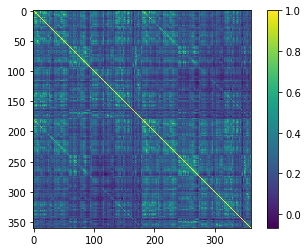

In [8]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation='none')
plt.colorbar()

Plot profile of FC values for a given seed parcel.

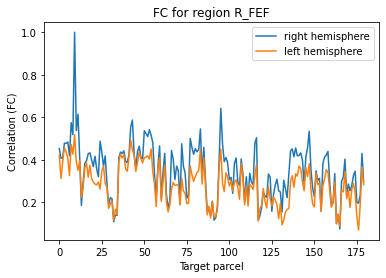

In [9]:
seed_roi = 'R_FEF'  # name of seed parcel
ind = regions["name"].index(seed_roi)

group_fc = fc.mean(axis=0)

# Plot the FC profile across the right and left hemisphere target regions
plt.plot(group_fc[:180, ind], label='right hemisphere')
plt.plot(group_fc[180:, ind], label='left hemisphere')
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target parcel")
plt.ylabel('Correlation (FC)')
plt.legend()
plt.show()

# Task data

## Access and load the data

In [10]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [11]:
run_names = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

bold_runs = [5, 6]  # Select motor task runs, index in run_names list

# Load task time series for each subject
timeseries_task = []
for subject in subjects:
  tsi = []
  for bold_run in bold_runs:
    tsi.append(load_timeseries(subject, bold_run))
  timeseries_task.append(tsi)

## Run a simple task analysis

In [12]:
### Function to load event time files (EVs)
def load_evs(data_loc, subject, bold_names, condition):
  out = []
  for bold_name in bold_names:
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{bold_name}/{condition}.txt"
    evs = np.loadtxt(ev_file, delimiter="\t")
    out.append(evs)
  return out

### Function to extract frames of interest
def frames_of_interest(evs_list):
    frames_list = []
    for evs in evs_list:
      frames = []
      for row in range(len(evs)):
        ## - determine when trial starts, rounded down
        start = int(np.floor(evs[row][0]/TR))

        ## - use trial duration to determine how many frames to include for trial
        duration = int(np.floor(evs[row][1] / TR))

        ## - use duration to calculation ending frame
        end = int(start + duration)

        ## - take the range of frames that correspond to this specific trial and append them to our frames vector
        frames = np.concatenate((frames, np.arange(start, end)), axis=0)

        ## - convert to int so frames can be used as an index and return
        frames = frames.astype(int)
      frames_list.append(frames)
    return frames_list

In [13]:
###  Generate an activation contrast map bewteen two conditions 

bold_names = [run_names[bold_run - 1] for bold_run in bold_runs]

conditions = ['lf','rf'] # specify two conditions within task (left foot and right foot)

contrast = []
for subject in subjects:
  evs_0 = load_evs(data_loc, subject, bold_names, conditions[0])
  evs_1 = load_evs(data_loc, subject, bold_names, conditions[1])


  cond_frames_0 = frames_of_interest(evs_0)
  cond_frames_1 = frames_of_interest(evs_1)

  ## - get average activation across condition for each parcel
  maps_0 = np.array([np.mean(timeseries_task[subject][i][:, f], axis=1) for i, f in enumerate(cond_frames_0)])
  maps_1 = np.array([np.mean(timeseries_task[subject][i][:, f], axis=1) for i, f in enumerate(cond_frames_1)])

  ## - calculate contrast by subtracting timeseries from each other
  sub_contrast = maps_0.mean(0) - maps_1.mean(0)
  contrast.append(sub_contrast)


Plot group-aveaged contrast "map"


Text(0, 0.5, 'Contrast')

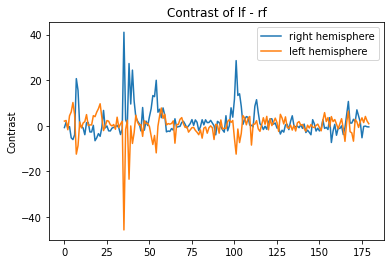

In [14]:
group_contrast = np.array(contrast).mean(0)

plt.plot(group_contrast[:180], label='right hemisphere') # Plot profile for right hemisphere
plt.plot(group_contrast[180:], label='left hemisphere') # Plot profile for left hemisphere
plt.legend()
plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.ylabel('Contrast')

## Characterize contrast by functional network

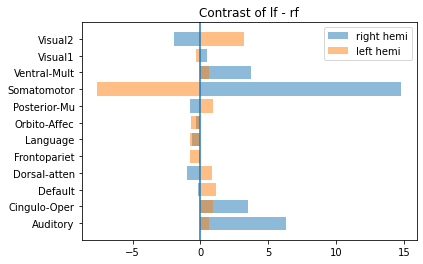

In [15]:
network_names = np.unique(regions["network"]) # Get unique network labels

# Get mean contrast value per network, for right hemisphere
vals_r = []
for network in network_names:
  inds = np.where(regions["network"][:180] == network)
  vals_r.append(group_contrast[:180][inds].mean())

# Get mean contrast value per network, for left hemisphere
vals_l = []
for network in network_names:
  inds = np.where(regions["network"][180:] == network)
  vals_l.append(group_contrast[180:][inds].mean())

# Plot mean contrast value per network, per hemisphere
plt.barh(network_names, vals_r, label='right hemi',alpha=0.5)
plt.barh(network_names, vals_l, label='left hemi',alpha=0.5)
plt.axvline(0)

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.legend()